In [2]:
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
#load csv file produced by processing sketch
def load_data(filename):
    converters = {0: lambda s: np.nan} # ignore row headers
    data = np.loadtxt(filename, delimiter=',', converters=converters)
    data = data[:,1:] #remove row headers
    return data

In [208]:
def hue_metric(h0,h1):
    return min(
        np.abs(h0-h1),
        np.abs(np.mod(h0+0.5,1)-np.mod(h1+0.5,1))
    )
def dist_matrix(ah0,ah1,sh0,sh1):
    hues = np.array([ah0,ah1,sh0,sh1])
    dists = np.fromfunction(np.vectorize(
        lambda i,j: hue_metric(hues[int(i)],hues[int(j)]) if i != j else np.nan),(4,4))
    return dists
#check if selected hues can be unambiguously paired with actual hues by hue distance
def check_pairing(ah0,ah1,sh0,sh1):
    dists = dist_matrix(ah0,ah1,sh0,sh1)
    closest = np.nanargmin(dists,axis=0)
    return len(closest) == len(set(closest))
def all_paired(data):
    return np.all([check_pairing(*d) for d in data.T])

#pair selected hues with actual hues
#by first pairing the closest (ah,sh)
def pair_hues(ah0,ah1,sh0,sh1):
    ahsh_dists = dist_matrix(ah0,ah1,sh0,sh1)[:2,2:4]
    closest_pair = np.unravel_index(np.argmin(ahsh_dists.ravel()),(2,2))
    closest_hue_pair = ((ah0,ah1)[closest_pair[0]],(sh0,sh1)[closest_pair[1]])
    other_hue_pair = ((ah0,ah1)[~closest_pair[0]],(sh0,sh1)[~closest_pair[1]])
    return dict(close = closest_hue_pair, far = other_hue_pair)
#given a pairing of the actual and selected hues,
#score by summing the distance between each pair
#lower score is better
def score_pairing(pairing):
    return hue_metric(*pairing['close']) + hue_metric(*pairing['far'])
def score_hues(ah0,ah1,sh0,sh1):
    return score_pairing(pair_hues(ah0,ah1,sh0,sh1))

Scores for each person tested

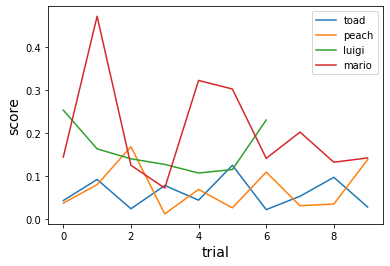

In [309]:
for name in "toad,peach,luigi,mario".split(','):
    data = load_data("data/" + name + ".csv")
    scores = [score_hues(*d) for d in data.T]
    plt.plot(scores,label=name)
    plt.xlabel('trial',fontsize=14)
    plt.ylabel('score',fontsize=14)
plt.legend()
plt.show()

Check to see if there is ambiguous pairing

ambiguous trials: [1 5 9]


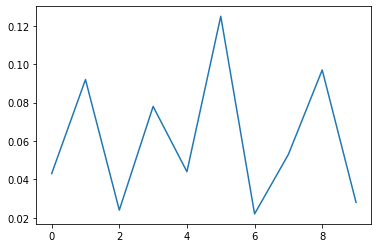

In [311]:
data = load_data("data/toad.csv")
ambiguous = [not check_pairing(*d) for d in data.T]
print("ambiguous trials:",np.arange(len(data.T))[ambiguous])

In [114]:
def get_euclid(hue):
    return np.array([f(np.exp(1j*2*np.pi*hue))
                     for f in (np.real,np.imag)])
def plot_color_disk(ax):
    color_wheel = plt.imread('./color-wheel.png')
    ax.imshow(color_wheel,interpolation='nearest',extent=(-1,1,-1,1))

Plot all tested contrasts

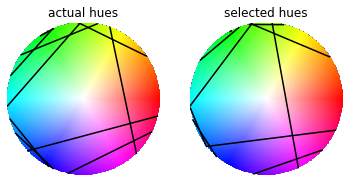

In [316]:
data = load_data("data/toad.csv")

fig, axes = plt.subplots(1,2)
ax = axes[0]
plot_color_disk(ax)

for h0,h1 in data[:2].T:
    #print(h0)
    line = np.array([get_euclid(h) for h in (h0,h1)])
    ax.plot(line.T[0],line.T[1],c='black')
    ax.set_aspect(1)
    ax.set_title('actual hues')
ax = axes[1]
plot_color_disk(ax)
for h0,h1 in data[2:4].T:
    #print(h0)
    line = np.array([get_euclid(h) for h in (h0,h1)])
    ax.plot(line.T[0],line.T[1],c='black')
    ax.set_aspect(1)
    ax.set_title('selected hues')
for ax in axes:
    ax.axis('off')
plt.show()

Compare actual (dotted line) vs selected (solid line) hue contrasts, sorted by score

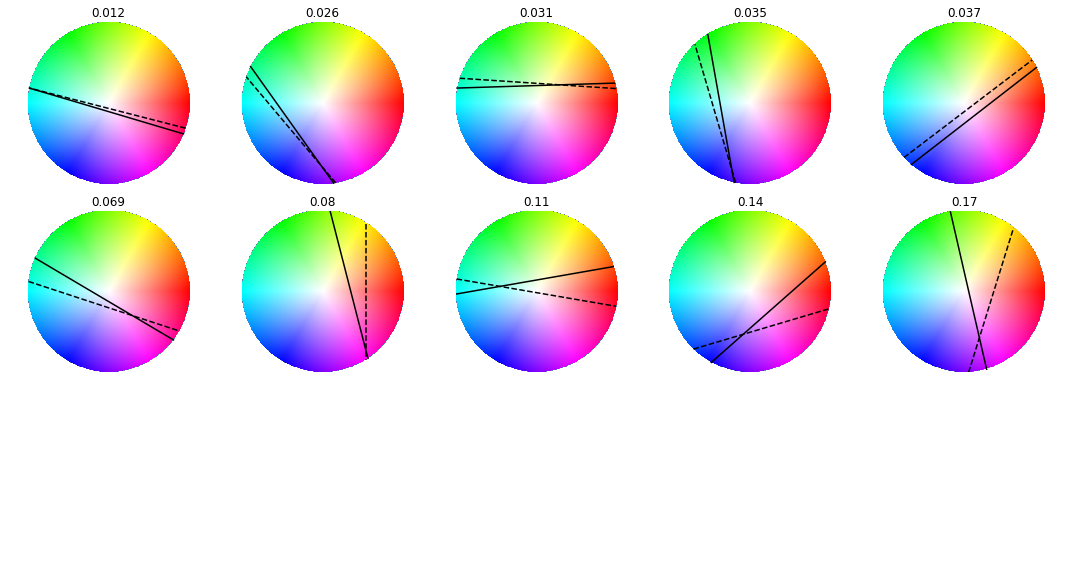

In [314]:
def plot_contrasts(data):
    scores = [score_hues(*d) for d in data.T]
    score_sort = np.argsort(scores)
    
    fig, axes = plt.subplots(3,5,figsize=(15,8))
    axes_iter = (ax for ax in axes.ravel())
    styles = ['-','--']
    
    for i in score_sort:
        ax = next(axes_iter)
        plot_color_disk(ax)
        #print(h0)
        line = np.array([get_euclid(h) for h in data[:2,i]])
        ax.plot(line.T[0],line.T[1],c='black',linestyle='--')
        line = np.array([get_euclid(h) for h in data[2:4,i]])
        ax.plot(line.T[0],line.T[1],c='black',linestyle='-')
        ax.set_aspect(1)
        ax.set_title("{0:1.2}".format(scores[i]))
        ax.axis('off')
    for ax in axes_iter:
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_contrasts(load_data("data/peach.csv"))

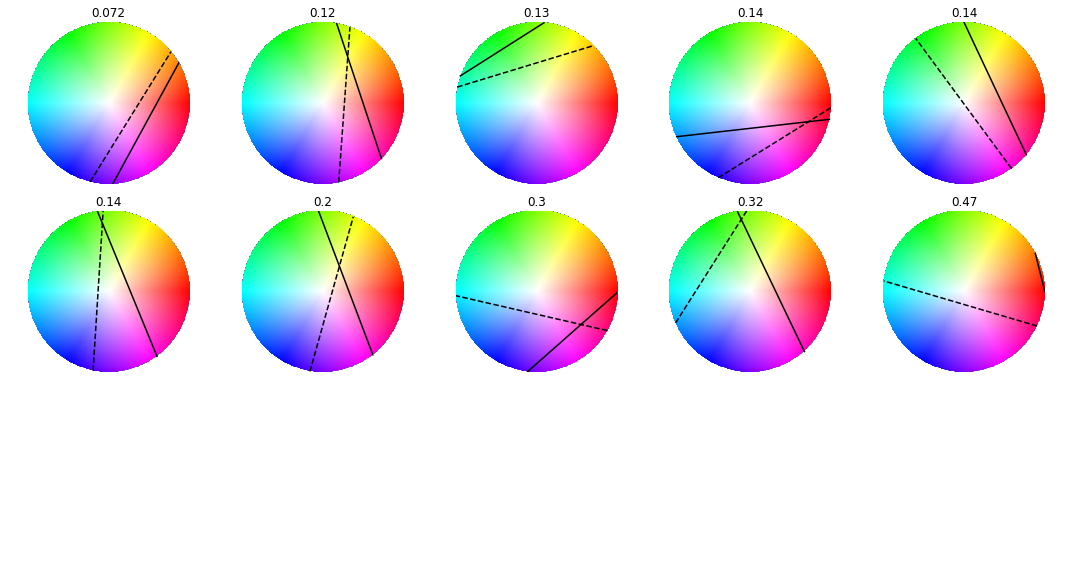

In [315]:
plot_contrasts(load_data("data/mario.csv"))